In [2]:
import pandas as pd
from pycaret.regression import *

df = pd.read_csv('consumption_temp.csv')

start_time = '2022-04-07 21:00:00'
end_time = '2022-06-07 21:00:00'
location = 'oslo'

start_time = pd.to_datetime(start_time)
end_time = pd.to_datetime(end_time)

data = df[df['location'].str.lower() == location.lower()]
data['time'] = pd.to_datetime(data['time'])

# Filter the training data based on the start and end time
data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]

# Create hour feature
data['hour'] = data['time'].dt.hour
# Create weekday feature
data['weekday'] = data['time'].dt.weekday

# Remove the last 5 days of consumption data
data['consumption'] = data['consumption'].shift(120)
data.dropna(subset=['consumption'], inplace=True)

In [3]:
regression_setup = setup(data=data, target='consumption', session_id=123,
                         numeric_features=['temperature', 'hour', 'weekday'], 
                         transform_target=True, data_split_shuffle=False)

,Description,Value
0,Session id,123
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(1345, 6)"
4,Transformed data shape,"(1345, 8)"
5,Transformed train set shape,"(941, 8)"
6,Transformed test set shape,"(404, 8)"
7,Numeric features,3
8,Date features,1
9,Categorical features,1


In [4]:
# Compare models to select the best one in the next block (comment if already selected)
# best_model = compare_models()


In [5]:
# Create the model with the desired model
model = create_model('lr')

tuned_model = tune_model(model)

final_model = finalize_model(tuned_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0722,0.0068,0.0822,-2.5356,0.0392,0.0635
1,0.0081,0.0001,0.0091,-1.5635,0.0059,0.0150
2,0.0073,0.0001,0.0093,-0.0550,0.0059,0.0125
3,0.0410,0.0021,0.0461,-2.7072,0.0269,0.0597
4,0.0196,0.0006,0.0245,-0.2908,0.0146,0.0292
5,0.0082,0.0001,0.0102,0.3317,0.0063,0.0133
6,0.0134,0.0003,0.0167,0.1537,0.0099,0.0195
7,0.0182,0.0005,0.0229,0.0168,0.0136,0.0270
8,0.0169,0.0005,0.0213,0.2437,0.0127,0.0249


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


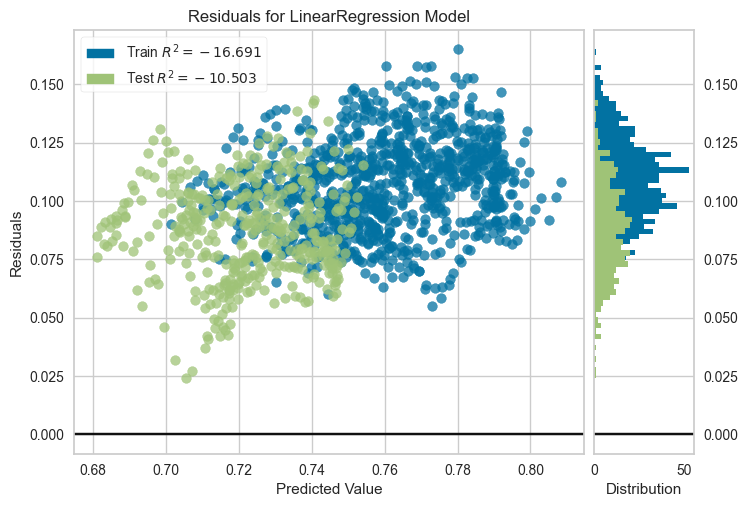

In [6]:
plot_model(final_model)

In [8]:
from datetime import timedelta

number_predict_hours = 24

# The last known time from the original data
last_time = data['time'].iloc[-1]

# Generating future timestamps for the next 24 hours (the hours we want to predict)
future_timestamps = [last_time + timedelta(hours=i) for i in range(1, number_predict_hours + 1)]

future_data = df[df['location'].str.lower() == location.lower()]
future_data['time'] = pd.to_datetime(future_data['time'])

# Limit future data to the next 24 hours after the last known time
future_data = future_data[(future_data['time'] > last_time) & (future_data['time'] <= future_timestamps[-1])]
future_hours = future_data['time'].dt.hour
future_weekdays = future_data['time'].dt.weekday
future_temperatures = future_data['temperature'].values

print(len(future_data))

# Creating the future_data DataFrame, which will be used for the prediction
future_data = pd.DataFrame({
    'time': future_timestamps,
    'temperature': future_temperatures,
    'location': location,
    'hour': future_hours,
    'weekday': future_weekdays
})

# Predict the consumption for the next 24 hours using the trained model
future_data['time'] = pd.to_datetime(future_data['time'])
predictions = predict_model(final_model, data=future_data)

24


In [10]:
predictions

,time,temperature,location,hour,weekday,prediction_label
7326,2022-06-07 22:00:00,13.500000,oslo,22,1,2.449626
7331,2022-06-07 23:00:00,13.200000,oslo,23,1,2.464552
7336,2022-06-08 00:00:00,12.600000,oslo,0,2,2.049193
7341,2022-06-08 01:00:00,12.900000,oslo,1,2,2.066730
7346,2022-06-08 02:00:00,13.400000,oslo,2,2,2.086405
7351,2022-06-08 03:00:00,12.900000,oslo,3,2,2.096507
7356,2022-06-08 04:00:00,12.900000,oslo,4,2,2.111603
7361,2022-06-08 05:00:00,12.900000,oslo,5,2,2.126841
7366,2022-06-08 06:00:00,13.000000,oslo,6,2,2.143229
7371,2022-06-08 07:00:00,14.200000,oslo,7,2,2.171011


<AxesSubplot: title={'center': 'Predictions for the next 24 hours'}, xlabel='time', ylabel='MV'>

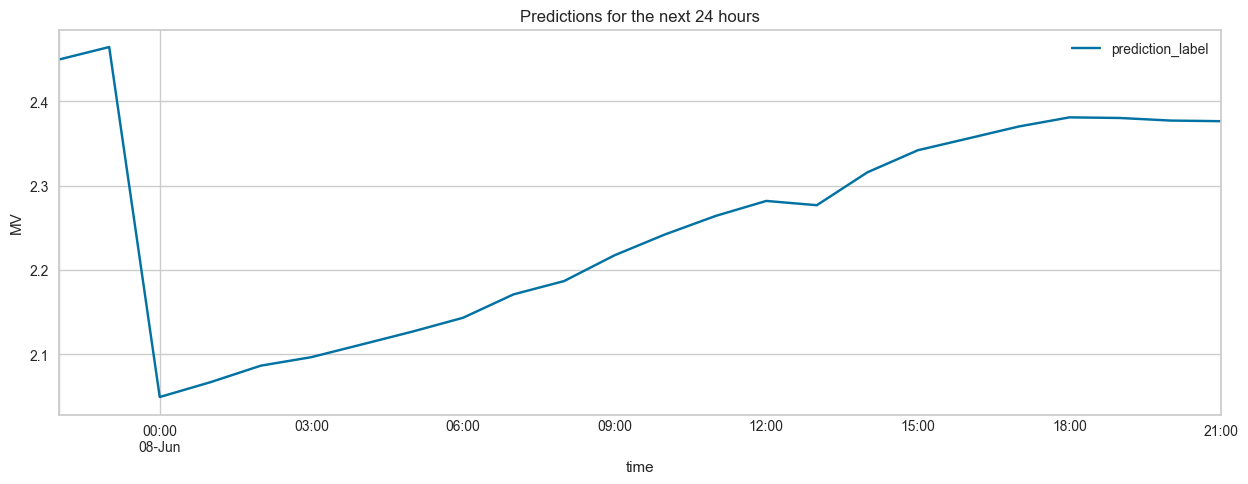

In [11]:
# Plot the predictions
predictions.plot(x='time', y='prediction_label', ylabel="MV", figsize=(15, 5), title=f'Predictions for the next {number_predict_hours} hours')